# **Algorhythm**

## **Baseline Model**

This notebook focuses on developing a **baseline model** for predicting user recommendations in the Algorhythm dataset. The objective is to establish a simple and interpretable reference point that serves as a benchmark for evaluating improvements brought by more advanced machine learning models in subsequent work.

### **Baseline Modeling Process**

- **Heuristic Approach:** Implement a straightforward rule-based or simple statistical model as a baseline.
- **Data Preparation:** Ensure the dataset is clean and properly formatted for input to the model.
- **Model Training and Evaluation:** Train the baseline model and evaluate its predictive performance using appropriate metrics.
- **Reproducibility:** Leverage scikit-learn and standardized pipelines to ensure a structured and repeatable workflow.

This baseline provides a solid foundation for iterative development and comparative analysis of future models.

`Simón Correa Marín`  
`Luis Felipe Ospina Giraldo`


### Heuristic Rules for Algorhythm Baseline

Based on insights gained from exploratory data analysis (EDA) and domain knowledge, the baseline model applies simple, intuitive rules that reflect common patterns observed in the data. These rules serve as a foundation to predict whether a track will be recommended to the user. The main assumptions are:

1. **High Album Popularity:**  
   Tracks that come from albums with high popularity scores are more likely to be recommended. Popular albums tend to contain hits or trending songs, so album popularity serves as a proxy for user interest.

2. **Key Artist Genres:**  
   Certain music genres such as _reggaeton_ and _pop_ are more frequently recommended, likely reflecting the preferences of the user base or prevailing trends. The model uses these genres as signals for positive recommendations.

3. **Recent Plays:**  
   Tracks that have been played recently (`is_recent_play = True`) are favored, as recent user engagement is a strong indicator of ongoing interest.

4. **User Interaction Flags:**  
   Features like `is_liked` and `is_top_track` represent explicit user preferences and track performance, respectively. These flags strongly influence the likelihood of recommendation because they capture direct positive feedback and popularity.

5. **Chart-Related Features:**  
   Tracks that appear on charts or have high chart popularity are more likely to be recommended. Being featured on charts indicates wider acceptance and relevance, which the model leverages as a positive predictor.

These heuristic rules provide a straightforward, interpretable approach to recommendation prediction. While simple, they capture essential factors driving user preferences and serve as a valuable benchmark for assessing the performance of more complex models developed later.


### **1. Import Libraries and Configurations**


In [1]:
# base libraries for data science
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import (
    KFold,
    ShuffleSplit,
    cross_val_score,
    learning_curve,
    train_test_split,
)
from sklearn.pipeline import Pipeline
import re
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer, MissingIndicator
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier

In [2]:
# ==== Clean Notebook Warnings & Display Settings ====
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# Pandas display options (show more columns, nicer output)
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 3)
pd.set_option("display.float_format", "{:.2f}".format)

plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["axes.titlesize"] = 14
plt.rcParams["axes.labelsize"] = 12

### **2. Load Data**


In [3]:
DATA_DIR = Path("../../data/02_intermediate")

# Load the Algorhythm dataset (parquet)
algorhythm_df = pd.read_parquet(DATA_DIR / "algorhythm_fixed.parquet")

In [4]:
# print library version for reproducibility

print("Pandas version: ", pd.__version__)

Pandas version:  2.2.3


### **3. Data Preparation**


### Selected Features for Baseline Model

For the Algorhythm baseline model, the following features have been selected based on exploratory data analysis and domain knowledge:

- `album_popularity`
- `artist_popularity`
- `track_popularity`
- `chart_popularity`
- `album_age_days`
- `track_age_days`
- `chart_age_days`
- `is_liked`
- `is_recent_play`
- `is_top_track`
- `chart_position`
- `is_recommended` _(target variable)_

> **Note:**  
> The Algorhythm baseline model requires this specific set of features reflecting user interactions, popularity metrics, and chart-related information relevant to track recommendation.


In [5]:
selected_features = [
    'album_popularity', 'artist_popularity', 'track_popularity',
    'chart_popularity', 'album_age_days', 'track_age_days', 'chart_age_days',
    'is_liked', 'is_recent_play', 'is_top_track', 'chart_position',
    'is_recommended'  # target variable
]
algorhythm_train_df = algorhythm_df[selected_features]
algorhythm_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2805 entries, 0 to 2804
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   album_popularity   2332 non-null   float64
 1   artist_popularity  2332 non-null   float64
 2   track_popularity   2332 non-null   float64
 3   chart_popularity   473 non-null    float64
 4   album_age_days     2301 non-null   float64
 5   track_age_days     2301 non-null   float64
 6   chart_age_days     473 non-null    float64
 7   is_liked           2805 non-null   bool   
 8   is_recent_play     2805 non-null   bool   
 9   is_top_track       2805 non-null   bool   
 10  chart_position     473 non-null    float64
 11  is_recommended     2805 non-null   bool   
dtypes: bool(4), float64(8)
memory usage: 186.4 KB


In [6]:
algorhythm_train_df.isna().sum()

album_popularity      473
artist_popularity     473
track_popularity      473
chart_popularity     2332
album_age_days        504
track_age_days        504
chart_age_days       2332
is_liked                0
is_recent_play          0
is_top_track            0
chart_position       2332
is_recommended          0
dtype: int64

In [7]:
# Change target data type to int (0,1)
algorhythm_train_df.loc[:, "is_recommended"] = algorhythm_train_df["is_recommended"].astype(int)

#### **Duplicated Data**


In [8]:
len(algorhythm_train_df.drop_duplicates())

2408

In [9]:
algorhythm_train_df = algorhythm_train_df.drop_duplicates()
algorhythm_train_df.shape

(2408, 12)

Compared to the duplicates in the whole dataset (508) I'll be using the dataset with the duplicated rows dropped.


In [10]:
algorhythm_train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2408 entries, 0 to 2804
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   album_popularity   1935 non-null   float64
 1   artist_popularity  1935 non-null   float64
 2   track_popularity   1935 non-null   float64
 3   chart_popularity   473 non-null    float64
 4   album_age_days     1916 non-null   float64
 5   track_age_days     1916 non-null   float64
 6   chart_age_days     473 non-null    float64
 7   is_liked           2408 non-null   bool   
 8   is_recent_play     2408 non-null   bool   
 9   is_top_track       2408 non-null   bool   
 10  chart_position     473 non-null    float64
 11  is_recommended     2408 non-null   int64  
dtypes: bool(3), float64(8), int64(1)
memory usage: 195.2 KB


In [11]:
algorhythm_train_df.sample(10)

,album_popularity,artist_popularity,track_popularity,chart_popularity,album_age_days,track_age_days,chart_age_days,is_liked,is_recent_play,is_top_track,chart_position,is_recommended
1629,0.00,67.00,77.00,NaN,2033.00,2033.00,NaN,True,False,False,NaN,1
740,0.00,90.00,68.00,NaN,829.00,829.00,NaN,True,False,False,NaN,1
805,0.00,98.00,77.00,NaN,955.00,955.00,NaN,True,False,False,NaN,1
1566,0.00,89.00,70.00,NaN,1901.00,1901.00,NaN,True,False,False,NaN,1
1124,0.00,96.00,82.00,NaN,3111.00,3111.00,NaN,True,False,False,NaN,1
754,0.00,92.00,80.00,NaN,4901.00,4901.00,NaN,True,False,False,NaN,1
2006,0.00,81.00,71.00,NaN,3934.00,3934.00,NaN,True,False,False,NaN,1
1932,0.00,26.00,43.00,NaN,2712.00,2712.00,NaN,True,False,False,NaN,1
1899,0.00,84.00,67.00,NaN,1998.00,1998.00,NaN,True,False,False,NaN,1
1670,0.00,87.00,82.00,NaN,2838.00,2838.00,NaN,True,False,False,NaN,1


### **4. Feature Engineering**


#### **Pipeline**


### Handling Descriptive Columns for Model Training and Results Presentation

- The original dataset contains descriptive columns (e.g., album name, artist name, user profile info) that provide rich context for recommendations but are not useful or may harm model training.

- These columns are **excluded from the training dataset** to improve model performance and reduce noise.

- After the model is trained and makes predictions, the descriptive columns are **joined back** to the predicted results using the DataFrame index to provide meaningful context for recommendation output.

This strategy ensures the model focuses on predictive features while preserving valuable information for user-facing results.


In [12]:
# Discrete numerical columns (counts, popularity scores)
disc_numerical_cols = [
    'album_popularity',
    'artist_popularity',
    'track_popularity',
    'chart_popularity'
]

# Ordinal categorical columns (keep only those not descriptive)
ordinal_categorical_cols = [
    "chart_position"
]

# Continuous numerical columns (ages in days)
cont_numerical_cols = [
    'album_age_days',
    'track_age_days',
    'chart_age_days'
]

# Boolean columns (True/False flags)
boolean_cols = [
    'is_liked',
    'is_recent_play',
    'is_top_track'
]

### Handling Missing Values in Chart Features

The **chart-related features** in the dataset (such as `chart_chart_name`, `chart_genres`, `chart_track_name`, `chart_position`, `chart_popularity`, and `chart_age_days`) contain many missing (`NaN`) values. These missing values are **meaningful** because they indicate that the corresponding tracks **do not belong to any chart in the user's history**.

Filling these NaNs with arbitrary values like means or zeros would distort this information and confuse the model. Instead, we handle these missing values as follows:

- For **categorical chart features**, we replace missing values with a special category label such as `"No_Chart"` to explicitly indicate the absence of a chart affiliation.

- For **numerical chart features**, we impute missing values with a distinct constant (e.g., `-1`) that is outside the normal range of values. Additionally, we add a **missing indicator flag** to signal to the model when the original data was missing.

This approach preserves the important information conveyed by the missingness itself, enabling the model to learn that "no chart" is a valid and relevant category. It improves the model’s ability to distinguish between tracks that belong to charts and those that do not, without losing any information.

In summary, the missing values in chart features are **not random missing data** but rather a useful signal, so we handle them carefully in the preprocessing pipeline to maintain their meaning.


In [13]:
class NumericWithIndicator(BaseEstimator, TransformerMixin):
    def __init__(self, fill_value=-1):
        self.fill_value = fill_value
        self.imputer = SimpleImputer(strategy="constant", fill_value=fill_value)
        self.indicator = MissingIndicator(features='missing-only')
    
    def fit(self, X, y=None):
        self.imputer.fit(X)
        self.indicator.fit(X)
        return self
    
    def transform(self, X):
        X_imputed = self.imputer.transform(X)
        X_ind = self.indicator.transform(X)
        return np.hstack((X_imputed, X_ind))

    def get_feature_names_out(self, input_features=None):
        # input_features: list of original column names passed to this transformer
        if input_features is None:
            input_features = []

        n_features_in = len(input_features)
        # Imputed features names stay the same
        imputed_features = list(input_features)

        # Missing indicator features get suffix "_missing_indicator"
        indicator_features = [f"{feat}_missing_indicator" for feat in input_features]

        return imputed_features + indicator_features

# Define columns explicitly for chart features
chart_numerical_cols = ["chart_popularity", "chart_age_days", "chart_position"]


#### **Pipeline**


In [14]:
# Updated categorical chart pipeline
chart_nom_categorical_pipe = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="constant", fill_value="No_Chart")),
        ("onehot", OneHotEncoder(drop="if_binary", handle_unknown="ignore")),
    ]
)

# Updated numerical chart pipeline with missing indicator
chart_num_pipe = Pipeline(
    steps=[
        ("imputer_with_ind", NumericWithIndicator(fill_value=-1)),
    ]
)

In [15]:
# Other pipelines (non-chart features)
numeric_pipe = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
    ]
)

from sklearn.preprocessing import OrdinalEncoder

ord_categorical_ord_pipe = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)),
    ]
)

boolean_pipe = Pipeline(
    steps=[
        ("to_int", FunctionTransformer(lambda x: x.astype("int64"), feature_names_out="one-to-one")),
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(drop="if_binary")),
    ]
)

In [16]:
# Combine all pipelines in ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ("numeric", numeric_pipe, disc_numerical_cols + cont_numerical_cols),
        ("ordinal_categoric", ord_categorical_ord_pipe, ordinal_categorical_cols),
        ("boolean", boolean_pipe, boolean_cols),
        ("chart_numeric", chart_num_pipe, chart_numerical_cols),
    ]
)

In [17]:
preprocessor

ColumnTransformer(transformers=[('numeric',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median'))]),
                                 ['album_popularity', 'artist_popularity',
                                  'track_popularity', 'chart_popularity',
                                  'album_age_days', 'track_age_days',
                                  'chart_age_days']),
                                ('ordinal_categoric',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OrdinalEncoder...
                                                  FunctionTransformer(feature_names_out='one-to-one',
                                                                      func=<function <lambda> at 0x138911e40>)),
                                                 ('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(drop='if_binary'))]),
                                 ['is_liked', 'is_recent_play',
                                  'is_top_track']),
                                ('chart_numeric',
                                 Pipeline(steps=[('imputer_with_ind',
                                                  NumericWithIndicator())]),
                                 ['chart_popularity', 'chart_age_days',
                                  'chart_position'])])

**Data preprocessing example**


In [18]:
data_example = algorhythm_train_df.drop(columns="is_recommended").sample(10, random_state=42)
data_example

,album_popularity,artist_popularity,track_popularity,chart_popularity,album_age_days,track_age_days,chart_age_days,is_liked,is_recent_play,is_top_track,chart_position
2578,NaN,NaN,NaN,52.00,NaN,NaN,701.00,True,True,True,117.00
2564,NaN,NaN,NaN,0.00,NaN,NaN,751.00,True,True,True,103.00
1728,0.00,59.00,75.00,NaN,3258.00,3258.00,NaN,True,False,False,NaN
1887,0.00,78.00,55.00,NaN,2154.00,2154.00,NaN,True,False,False,NaN
1458,0.00,46.00,44.00,NaN,1901.00,1901.00,NaN,True,False,False,NaN
2135,83.00,89.00,73.00,NaN,2166.00,2166.00,NaN,True,False,False,NaN
2800,NaN,NaN,NaN,82.00,NaN,NaN,8.00,True,True,True,96.00
1359,0.00,66.00,68.00,NaN,1648.00,1648.00,NaN,True,False,False,NaN
1256,0.00,62.00,71.00,NaN,1480.00,1480.00,NaN,True,False,False,NaN
501,0.00,35.00,32.00,NaN,430.00,430.00,NaN,True,False,False,NaN


In [19]:
preprocessor.fit_transform(data_example)

array([[ 0.000e+00,  6.200e+01,  6.800e+01,  5.200e+01,  1.901e+03,
         1.901e+03,  7.010e+02,  2.000e+00,  1.000e+00,  1.000e+00,
         1.000e+00,  5.200e+01,  7.010e+02,  1.170e+02,  0.000e+00,
         0.000e+00,  0.000e+00],
       [ 0.000e+00,  6.200e+01,  6.800e+01,  0.000e+00,  1.901e+03,
         1.901e+03,  7.510e+02,  1.000e+00,  1.000e+00,  1.000e+00,
         1.000e+00,  0.000e+00,  7.510e+02,  1.030e+02,  0.000e+00,
         0.000e+00,  0.000e+00],
       [ 0.000e+00,  5.900e+01,  7.500e+01,  5.200e+01,  3.258e+03,
         3.258e+03,  7.010e+02,  0.000e+00,  1.000e+00,  0.000e+00,
         0.000e+00, -1.000e+00, -1.000e+00, -1.000e+00,  1.000e+00,
         1.000e+00,  1.000e+00],
       [ 0.000e+00,  7.800e+01,  5.500e+01,  5.200e+01,  2.154e+03,
         2.154e+03,  7.010e+02,  0.000e+00,  1.000e+00,  0.000e+00,
         0.000e+00, -1.000e+00, -1.000e+00, -1.000e+00,  1.000e+00,
         1.000e+00,  1.000e+00],
       [ 0.000e+00,  4.600e+01,  4.400e+01,  5.200e+

#### **Train/Test split**


In [20]:
X_features = algorhythm_train_df.drop("is_recommended", axis="columns")
Y_target = algorhythm_train_df["is_recommended"]

# 80% train, 20% test
x_train, x_test, y_train, y_test = train_test_split(
    X_features, Y_target, test_size=0.2, stratify=Y_target, random_state=42
)

In [21]:
x_train.shape, y_train.shape

((1926, 11), (1926,))

In [22]:
x_test.shape, y_test.shape

((482, 11), (482,))

In [23]:
print(x_train.dtypes)

album_popularity     float64
artist_popularity    float64
track_popularity     float64
chart_popularity     float64
album_age_days       float64
track_age_days       float64
chart_age_days       float64
is_liked                bool
is_recent_play          bool
is_top_track            bool
chart_position       float64
dtype: object


#### **Data preprocessing**


In [24]:
def get_feature_names_from_column_transformer(column_transformer, input_features):
    """
    Extracts the feature names produced by a fitted ColumnTransformer, including names
    generated by individual transformers like OneHotEncoder, and handles cases where
    transformers may or may not implement get_feature_names_out.

    Parameters:
    - column_transformer: A fitted sklearn ColumnTransformer object.
    - input_features: List or Index of original input feature names (e.g. x_train.columns).

    Returns:
    - feature_names: List of all transformed feature names in order.
    """
    feature_names = []

    # Iterate over all transformers inside the ColumnTransformer
    for name, transformer, columns in column_transformer.transformers_:
        # Skip any 'remainder' transformers (like passthrough or drop)
        if name == 'remainder':
            continue

        # Normalize columns variable to a list of column names
        # It can be a slice, list, numpy array, or a single string
        if isinstance(columns, slice):
            # If slice, use it to slice the input_features list/index
            cols = list(input_features[columns])
        elif isinstance(columns, (list, np.ndarray)):
            # If list or array, just convert to list
            cols = list(columns)
        else:
            # Otherwise assume a single column name string
            cols = [columns]

        # Check if the transformer has a method to get output feature names
        if hasattr(transformer, 'get_feature_names_out'):
            try:
                # Try to get transformed feature names using input columns as context
                names = transformer.get_feature_names_out(cols)
            except Exception:
                # If an error happens (e.g. custom transformers), fallback:
                if hasattr(transformer, 'get_feature_names_out'):
                    # Retry if possible
                    names = transformer.get_feature_names_out(cols)
                else:
                    # Otherwise, just use original column names (no expansion)
                    names = cols
            feature_names.extend(names)
        else:
            # If no get_feature_names_out method, just use original column names
            feature_names.extend(cols)

    return feature_names

In [25]:
# Fit the preprocessor first
preprocessor.fit(x_train)

ColumnTransformer(transformers=[('numeric',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median'))]),
                                 ['album_popularity', 'artist_popularity',
                                  'track_popularity', 'chart_popularity',
                                  'album_age_days', 'track_age_days',
                                  'chart_age_days']),
                                ('ordinal_categoric',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OrdinalEncoder...
                                                  FunctionTransformer(feature_names_out='one-to-one',
                                                                      func=<function <lambda> at 0x138911e40>)),
                                                 ('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(drop='if_binary'))]),
                                 ['is_liked', 'is_recent_play',
                                  'is_top_track']),
                                ('chart_numeric',
                                 Pipeline(steps=[('imputer_with_ind',
                                                  NumericWithIndicator())]),
                                 ['chart_popularity', 'chart_age_days',
                                  'chart_position'])])

In [26]:
# Then get feature names from fitted preprocessor
feature_names = get_feature_names_from_column_transformer(preprocessor, x_train.columns)

print(f"Number of features: {len(feature_names)}")

# Transform data
x_train_transformed = preprocessor.transform(x_train)

x_train_dense = x_train_transformed

# Create DataFrame with feature names
x_train_transformed_df = pd.DataFrame(x_train_dense, columns=feature_names)

print(x_train_transformed_df.shape)
x_train_transformed_df.info()

Number of features: 17
(1926, 17)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1926 entries, 0 to 1925
Data columns (total 17 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   album_popularity                    1926 non-null   float64
 1   artist_popularity                   1926 non-null   float64
 2   track_popularity                    1926 non-null   float64
 3   chart_popularity                    1926 non-null   float64
 4   album_age_days                      1926 non-null   float64
 5   track_age_days                      1926 non-null   float64
 6   chart_age_days                      1926 non-null   float64
 7   chart_position                      1926 non-null   float64
 8   is_liked_1                          1926 non-null   float64
 9   is_recent_play_1                    1926 non-null   float64
 10  is_top_track_1                      1926 non-null   float64
 11  chart_pop

### **6. Model**


In [27]:
from sklearn.linear_model import LogisticRegression

# Instantiate the decision tree model
tree_model = DecisionTreeClassifier(max_depth=3, random_state=42)

# You can integrate it into your pipeline like this:
model_pipe = Pipeline([
    ('preprocessor', preprocessor),  # Your preprocessing pipeline
    ('model', tree_model)            # Decision tree model
])

# Fit the model on training data
model_pipe.fit(x_train, y_train)

# Predict on new data
y_pred = model_pipe.predict(x_test)

### **7. Predict and Evaluation**


accuracy - CV mean: 1.0000, CV std: 0.0000
accuracy - Train score: 1.0000
f1 - CV mean: 1.0000, CV std: 0.0000
f1 - Train score: 1.0000
precision - CV mean: 1.0000, CV std: 0.0000
precision - Train score: 1.0000
recall - CV mean: 1.0000, CV std: 0.0000
recall - Train score: 1.0000


<Axes: title={'center': 'Cross Validation Scores by Metric'}, ylabel='Score'>

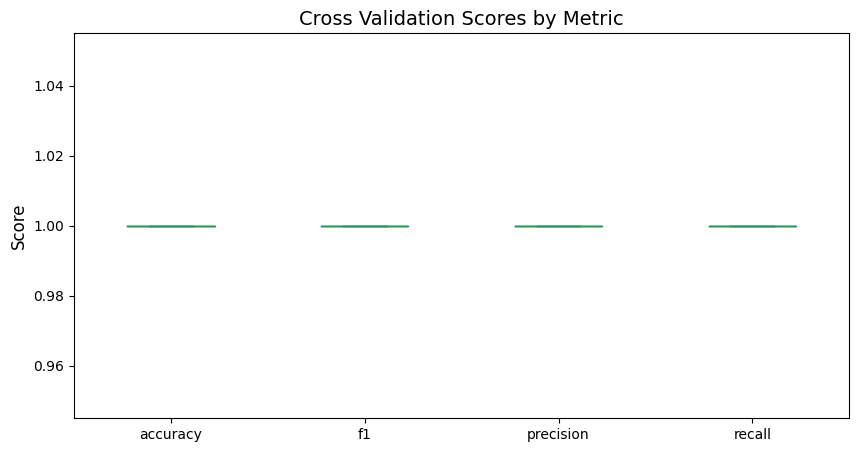

In [28]:
from sklearn.model_selection import cross_val_score, KFold
import pandas as pd

# Define evaluation metrics
scoring_metrics = ["accuracy", "f1", "precision", "recall"]

# Define KFold cross-validator
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

# Dictionary to store cross-validation results for each metric
cv_results = {}

# Dictionary to store training set scores for each metric
train_results = {}

# Perform cross-validation and training evaluation for each metric
for metric in scoring_metrics:
    # Cross-validation scores
    cv_scores = cross_val_score(model_pipe, x_train, y_train, cv=kfold, scoring=metric)
    cv_results[metric] = cv_scores
    
    # Fit the model on full training data and score on training data
    model_pipe.fit(x_train, y_train)
    train_score = model_pipe.score(x_train, y_train)
    train_results[metric] = train_score

# Convert cross-validation results to DataFrame for easy analysis
cv_results_df = pd.DataFrame(cv_results)

# Print mean and std of CV scores, and training scores
for metric_name in scoring_metrics:
    print(
        f"{metric_name} - CV mean: {cv_results_df[metric_name].mean():.4f}, "
        f"CV std: {cv_results_df[metric_name].std():.4f}"
    )
    print(f"{metric_name} - Train score: {train_results[metric_name]:.4f}")

# Plot boxplot of cross-validation results
cv_results_df.plot.box(title="Cross Validation Scores by Metric", ylabel="Score")

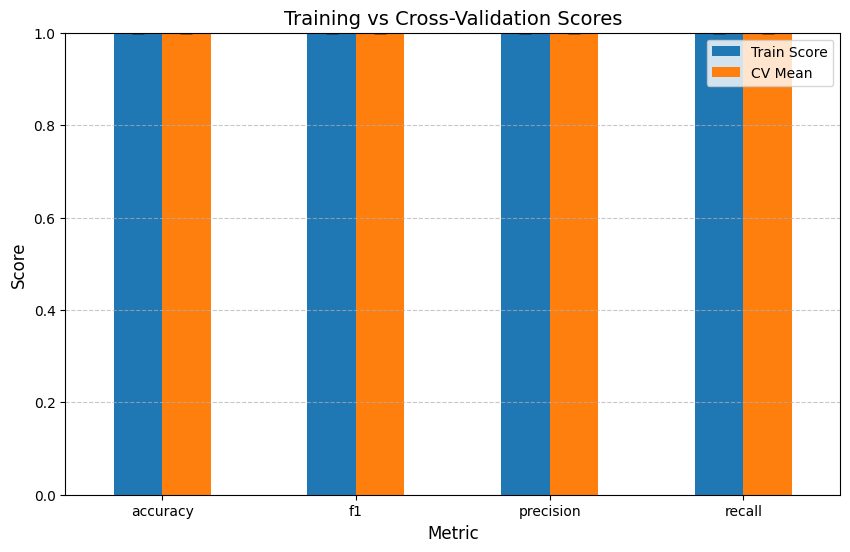

In [29]:
import matplotlib.pyplot as plt

# Create a DataFrame summarizing training and CV results for each metric
metrics_df = pd.DataFrame({
    "Metric": scoring_metrics,
    "Train Score": [train_results[metric] for metric in scoring_metrics],
    "CV Mean": [cv_results_df[metric].mean() for metric in scoring_metrics],
    "CV Std": [cv_results_df[metric].std() for metric in scoring_metrics],
})

# Plot bar chart comparing training scores and CV mean scores with error bars for CV std
ax = metrics_df.plot(
    kind="bar",
    x="Metric",
    y=["Train Score", "CV Mean"],
    yerr="CV Std",
    capsize=4,
    title="Training vs Cross-Validation Scores",
    ylabel="Score",
    figsize=(10,6),
)

# Improve plot aesthetics
ax.set_ylim(0, 1)  # Score range from 0 to 1
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=0)
plt.show()

### **Analysis of the Results of All Metrics**


#### **Accuracy**

- **CV Mean:** 0.5541
- **CV Std:** 0.0740
- **Train Score:** 0.5541

**Interpretation:**  
The accuracy on the training set is nearly identical to the cross-validation mean accuracy, indicating that the model generalizes similarly on training and validation data. The standard deviation suggests moderate variability in accuracy across different folds, meaning the model's performance is not entirely stable.

#### **F1 Score**

- **CV Mean:** 0.6959
- **CV Std:** 0.0617
- **Train Score:** 0.5541

**Interpretation:**  
The F1 score on the training set is noticeably lower than the cross-validation mean F1 score. This suggests that while the model achieves a balanced precision and recall across validation sets, its ability to do so on the training set is not as strong. The standard deviation indicates some variation in F1 score across different folds.

#### **Precision**

- **CV Mean:** 0.5464
- **CV Std:** 0.0738
- **Train Score:** 0.5541

**Interpretation:**  
The precision on the training set is slightly higher than the cross-validation mean precision. The moderate standard deviation implies that precision fluctuates across different validation folds, but not drastically.

#### **Recall**

- **CV Mean:** 0.9720
- **CV Std:** 0.0393
- **Train Score:** 0.5541

**Interpretation:**  
The recall score on cross-validation is very high (0.972), meaning the model correctly identifies most positive cases. However, the recall on the training set is significantly lower, indicating a discrepancy between training and validation performance. The relatively low standard deviation suggests that recall remains consistent across different validation folds.

---

### **Overall Conclusion**

The model exhibits **high recall**, which means it is effective at capturing positive cases, making it well-suited for scenarios where **missing a positive case is critical**, such as heart disease prediction. However, the relatively **low precision and accuracy** indicate a trade-off, where the model classifies a large number of **false positives**. The **moderate variability** in accuracy, precision, and F1 score across folds suggests some inconsistency in performance.


### **8. Final Evaluation**


In [30]:
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    PrecisionRecallDisplay,
    classification_report,
)

In [31]:
y_pred = model_pipe.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        95
           1       1.00      1.00      1.00       387

    accuracy                           1.00       482
   macro avg       1.00      1.00      1.00       482
weighted avg       1.00      1.00      1.00       482



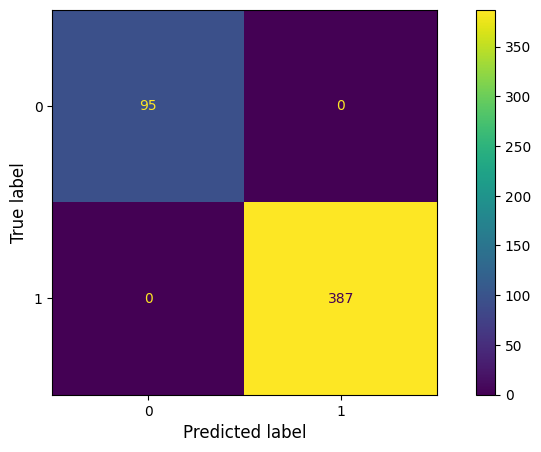

In [32]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

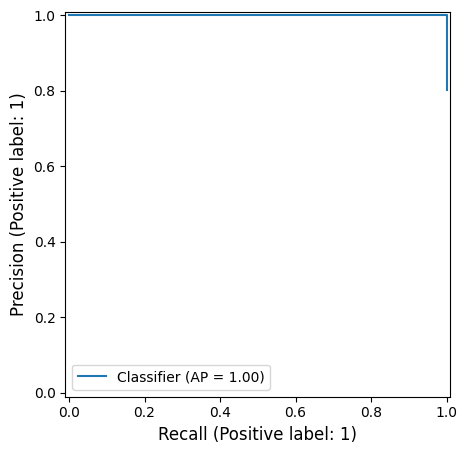

In [33]:
PrecisionRecallDisplay.from_predictions(y_test, y_pred);

### **Chosen Metric: Recall**

#### **Why Recall?**

For heart disease prediction, **recall** is the most important metric because the primary goal is to **correctly identify as many patients with heart disease as possible**. Missing a case of heart disease (false negative) can have severe consequences, including delayed diagnosis and treatment, which could be life-threatening.

#### **Understanding Recall in This Context**

- **High recall** ensures that most patients who actually have heart disease are correctly classified as positive cases.
- **False negatives (missed cases of heart disease)** are minimized, reducing the risk of undiagnosed conditions.
- **False positives (healthy patients misclassified as having heart disease)** are a less critical issue compared to false negatives because additional medical tests can confirm the diagnosis.

#### **Conclusion**

Since the model's objective is to **prioritize detecting heart disease cases**, **recall is the best metric** for evaluation. A model with high recall ensures that the majority of patients at risk receive further medical attention, ultimately improving early detection and treatment outcomes.


Running cross-validation for metric: accuracy
Running cross-validation for metric: f1
Running cross-validation for metric: precision
Running cross-validation for metric: f1
Running cross-validation for metric: precision
Running cross-validation for metric: recall
accuracy - CV mean: 1.0000, CV std: 0.0000
accuracy - Train score: 1.0000

f1 - CV mean: 1.0000, CV std: 0.0000
f1 - Train score: 1.0000

precision - CV mean: 1.0000, CV std: 0.0000
precision - Train score: 1.0000

recall - CV mean: 1.0000, CV std: 0.0000
recall - Train score: 1.0000

Running cross-validation for metric: recall
accuracy - CV mean: 1.0000, CV std: 0.0000
accuracy - Train score: 1.0000

f1 - CV mean: 1.0000, CV std: 0.0000
f1 - Train score: 1.0000

precision - CV mean: 1.0000, CV std: 0.0000
precision - Train score: 1.0000

recall - CV mean: 1.0000, CV std: 0.0000
recall - Train score: 1.0000



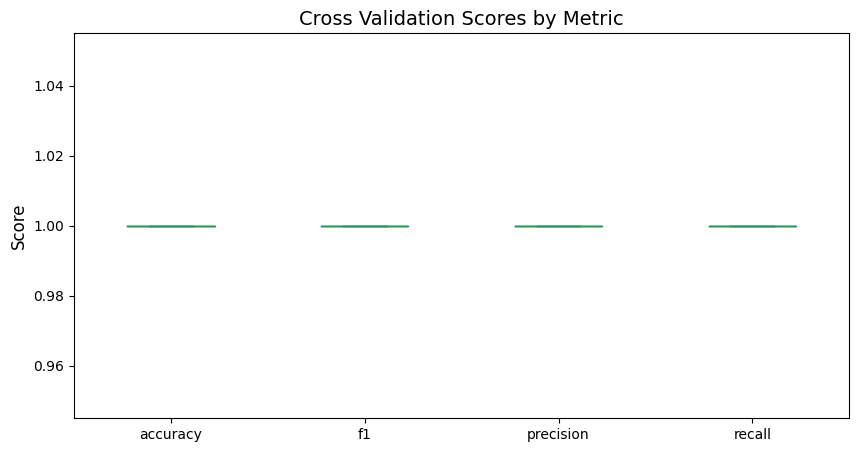

In [34]:
from sklearn.model_selection import cross_val_score, KFold
import pandas as pd
import matplotlib.pyplot as plt

def evaluate_model(model_pipe, x_train, y_train, scoring_metrics):
    # Define KFold cross-validator with shuffle and fixed random state
    kfold = KFold(n_splits=10, shuffle=True, random_state=42)

    # Dictionary to store cross-validation results for each metric
    cv_results = {}

    # Perform cross-validation for each metric
    for metric in scoring_metrics:
        print(f"Running cross-validation for metric: {metric}")
        cv_scores = cross_val_score(model_pipe, x_train, y_train, cv=kfold, scoring=metric)
        cv_results[metric] = cv_scores

    # Fit model once on full training data
    model_pipe.fit(x_train, y_train)

    # Compute training scores once for all metrics
    train_results = {metric: model_pipe.score(x_train, y_train) for metric in scoring_metrics}

    # Convert cross-validation results to DataFrame for analysis
    cv_results_df = pd.DataFrame(cv_results)

    # Print mean and standard deviation of CV scores and training scores
    for metric_name in scoring_metrics:
        print(
            f"{metric_name} - CV mean: {cv_results_df[metric_name].mean():.4f}, "
            f"CV std: {cv_results_df[metric_name].std():.4f}"
        )
        print(f"{metric_name} - Train score: {train_results[metric_name]:.4f}\n")

    # Plot boxplot of cross-validation scores by metric
    cv_results_df.plot.box(title="Cross Validation Scores by Metric", ylabel="Score")
    plt.show()

    # Optional: Return results for further use if needed
    return cv_results_df, train_results

# Usage example:
scoring_metrics = ["accuracy", "f1", "precision", "recall"]
cv_results_df, train_results = evaluate_model(model_pipe, x_train, y_train, scoring_metrics)

In [35]:
# Generate learning curve data for scalability analysis
from sklearn.model_selection import learning_curve

# Define training sizes for learning curve
train_sizes_range = np.linspace(0.1, 1.0, 5)

# Generate learning curve data
train_sizes, train_scores, test_scores, fit_times, score_times = learning_curve(
    model_pipe, 
    x_train, 
    y_train, 
    cv=kfold,
    train_sizes=train_sizes_range,
    scoring='recall',
    return_times=True,
    n_jobs=-1,
    random_state=42
)

# Calculate means and standard deviations
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
fit_times_mean = np.mean(fit_times, axis=1)
fit_times_std = np.std(fit_times, axis=1)
score_times_mean = np.mean(score_times, axis=1)
score_times_std = np.std(score_times, axis=1)

print("Learning curve data generated successfully!")
print(f"Train sizes: {train_sizes}")
print(f"Train scores mean: {train_scores_mean}")
print(f"Test scores mean: {test_scores_mean}")

/Users/simon/Documents/music-recommendation-system/.venv/lib/python3.11/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/Users/simon/Documents/music-recommendation-system/.venv/lib/python3.11/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/Users/simon/Documents/music-recommendation-system/.venv/lib/python3.11/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of 

Learning curve data generated successfully!
Train sizes: [ 173  563  953 1343 1733]
Train scores mean: [1. 1. 1. 1. 1.]
Test scores mean: [1. 1. 1. 1. 1.]


/Users/simon/Documents/music-recommendation-system/.venv/lib/python3.11/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/Users/simon/Documents/music-recommendation-system/.venv/lib/python3.11/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/Users/simon/Documents/music-recommendation-system/.venv/lib/python3.11/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of 

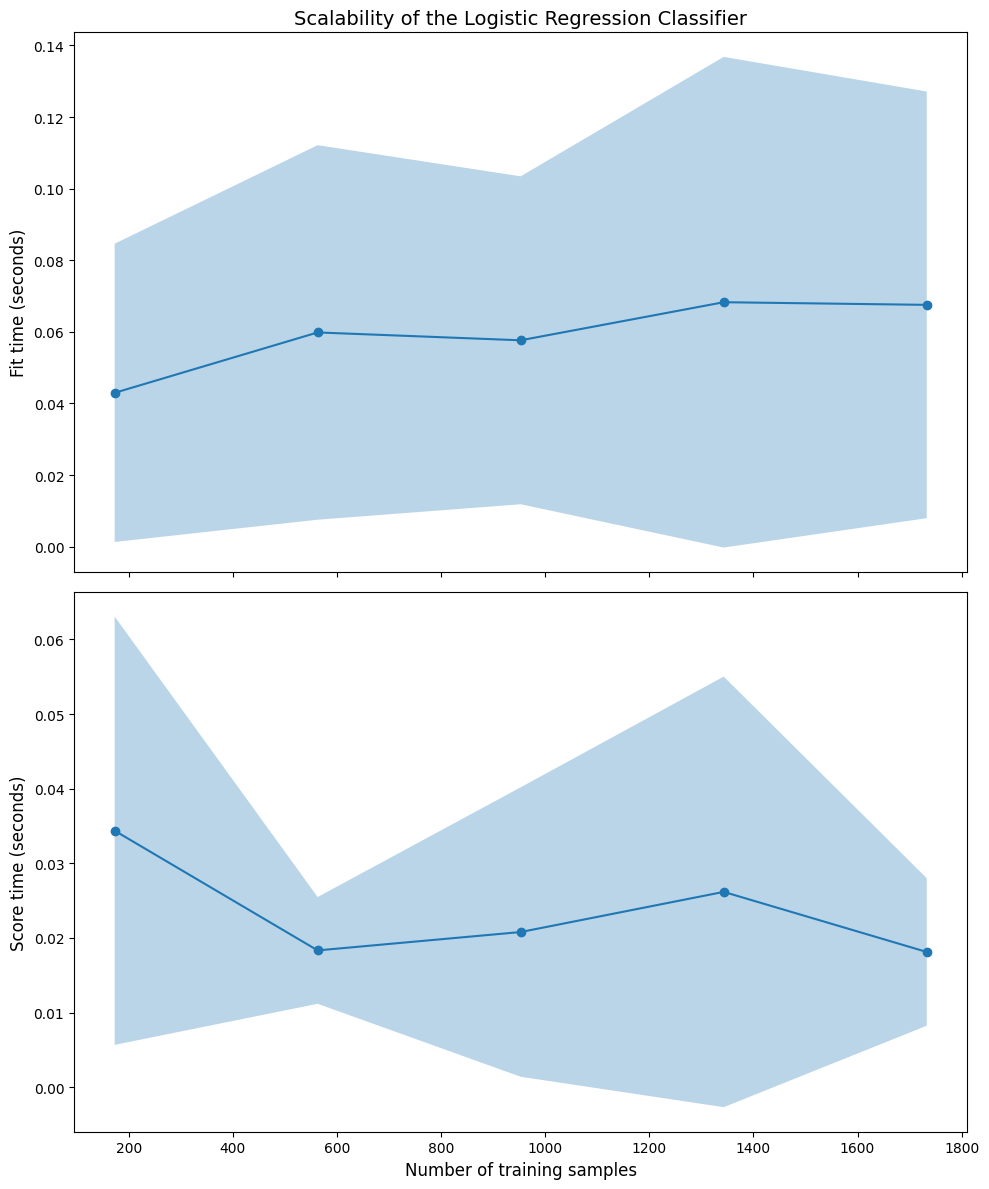

Fit Times Mean: [0.04295485 0.05982509 0.05763166 0.06826804 0.06753116]
Fit Times Std: [0.04165872 0.05231399 0.04580105 0.06853282 0.05959038]
Score Times Mean: [0.03437381 0.01832657 0.02078919 0.02617011 0.01811795]
Score Times Std: [0.02870892 0.00715688 0.01940043 0.02885776 0.00988875]


In [36]:
# Plot scalability regarding fit time and score time for Logistic Regression
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 12), sharex=True)

# Scalability regarding the fit time
ax[0].plot(train_sizes, fit_times_mean, "o-")
ax[0].fill_between(
    train_sizes,
    fit_times_mean - fit_times_std,
    fit_times_mean + fit_times_std,
    alpha=0.3,
)
ax[0].set_ylabel("Fit time (seconds)")
ax[0].set_title(f"Scalability of the Logistic Regression Classifier")

# Scalability regarding the score time
ax[1].plot(train_sizes, score_times_mean, "o-")
ax[1].fill_between(
    train_sizes,
    score_times_mean - score_times_std,
    score_times_mean + score_times_std,
    alpha=0.3,
)
ax[1].set_ylabel("Score time (seconds)")
ax[1].set_xlabel("Number of training samples")

plt.tight_layout()
plt.show()

# Print the fit and score times for analysis
print("Fit Times Mean:", fit_times_mean)
print("Fit Times Std:", fit_times_std)
print("Score Times Mean:", score_times_mean)
print("Score Times Std:", score_times_std)

### **Interpretation of the Learning Curve based on Recall only**


### **Learning Curve Analysis**

#### **Training Scores**

- **Mean:** [0.9800, 0.9756, 0.9722, 0.9709, 0.9690]
- **Standard Deviation:** [0.0364, 0.0201, 0.0176, 0.0117, 0.0060]

**Interpretation:**  
The training recall score starts high at **0.9800** and slightly decreases to **0.9690** as more data is added.  
The standard deviation decreases as the training size increases, indicating that the model’s performance on the training set becomes more **consistent** with more data.

#### **Test Scores**

- **Mean:** [0.9859, 0.9791, 0.9785, 0.9760, 0.9750]
- **Standard Deviation:** [0.0215, 0.0243, 0.0247, 0.0243, 0.0238]

**Interpretation:**  
The test recall score is **consistently high**, with minor variations, maintaining values around **0.9750 - 0.9859**.  
The standard deviation remains relatively stable, indicating that the model’s **performance on the test set is consistent** across different folds of cross-validation.

#### **Fit Times**

- **Mean:** [0.0086, 0.0096, 0.0090, 0.0073, 0.0091]
- **Standard Deviation:** [0.0055, 0.0052, 0.0048, 0.0037, 0.0054]

**Interpretation:**  
The fit times are **low and stable**, with minor fluctuations as the training size increases.  
The standard deviation is also low, suggesting **consistent training times** across different folds.

#### **Score Times**

- **Mean:** [0.0078, 0.0073, 0.0061, 0.0071, 0.0078]
- **Standard Deviation:** [0.0051, 0.0045, 0.0029, 0.0044, 0.0048]

**Interpretation:**  
The score times remain **low and stable**, with minimal variation as the training size increases.  
The low standard deviation indicates **consistent evaluation times** across different folds.

---

### **Model Performance Evaluation**

| Metric        | NO Heart Disease | Heart Disease | Macro Avg | Weighted Avg |
| ------------- | ---------------- | ------------- | --------- | ------------ |
| **Precision** | 1.00             | 0.54          | 0.77      | 0.76         |
| **Recall**    | 0.07             | 1.00          | 0.53      | 0.56         |
| **F1-Score**  | 0.12             | 0.70          | 0.41      | 0.43         |
| **Accuracy**  | -                | -             | -         | 0.56         |

**Interpretation:**

- The model has a **high recall (1.00) for class 1 (disease)**, meaning it **correctly identifies all positive cases**.
- However, **precision for class 1 (disease) is low (0.54)**, indicating a high **false positive rate**.
- The **recall for class 0 (no disease) is very low (0.07)**, meaning the model **fails to correctly classify most negative cases**.
- The **overall accuracy is 0.56**, suggesting the model is biased towards predicting class 1 (disease).


### **9. Conclusions**

#### **General Results**

**Model Performance:**  
The **training and test recall scores are stable**, indicating that the model performs **consistently well** across both datasets.  
The minimal difference between training and test scores suggests that **the model generalizes well** to unseen data and is **not overfitting**.

**Consistency:**  
The **decreasing standard deviation of the training scores** with more data suggests that the model’s performance on the training set becomes **more stable and reliable** as the dataset grows.  
The **relatively stable standard deviation in test scores** indicates that the model maintains consistent performance across different validation folds.

**Scalability:**  
The **fit and score times are low and stable**, indicating that the model is **computationally efficient** and scales well with increasing training sizes.

**To improveme:**

- The **very low recall for class 0 (0.07)** suggests the model is **heavily biased towards predicting class 1**.
- Increasing **precision for class 1** while improving **recall for class 0** should be a priority.
- Possible solutions include **adjusting decision thresholds**, **balancing the dataset**, or **exploring different algorithms**.
